In [2]:
import os
import glob

from typing import Tuple, List, Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

import attn_dl
import attn_model
import scoring

In [3]:
torch.manual_seed(0)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Model Training

In [5]:
def ou_loss(output, target):
    loss = 0
    i = 0
    while i < len(output) - 1:
        loss += abs(target[i] + target[i+1] - output[i] - output[i+1])
        i += 2
    return loss/(len(output)/2.)

In [6]:
def spread_loss(output, target):
    loss = 0
    i = 0
    while i < len(output) - 1:
        loss += abs((target[i+1] - target[i]) - (output[i+1] - output[i]))
        i += 2
    return loss/(len(output)/2.)

In [7]:
# Roughly follows https://pytorch.org/tutorials/beginner/nn_tutorial.html#

# Model hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 0.0001

### Comparing Heads at Depth = 2

In [8]:
train_losses = []
validate_losses = []
test_losses = []
heads = [1,2,4,8,16,32]
loss_func = F.smooth_l1_loss
_, x_train, y_train = attn_dl.load_vectorized_data('train')
_, x_validate, y_validate = attn_dl.load_vectorized_data('dev')

for head in heads:
    model, losses = attn_model.train_model(num_epochs, batch_size, learning_rate, heads = head, depth = 2, loss_func= loss_func)
    # Training error
    print("{} HEAD RESULTS".format(head))
    train_diff = loss_func(model(x_train), y_train).detach()
    print("Training Error: ", train_diff)
    ## Validation Performance
    # Total Loss on Validation Set
    total_diff = loss_func(model(x_validate), y_validate).detach()
    print("Validation Error: ", total_diff)
    # Error on test set
    i_test, x_test, y_test = attn_dl.load_vectorized_data('test')
    y_predicted = model(x_test)
    test_error = loss_func(y_predicted, y_test)
    print("Test Error: ", loss_func(y_predicted, y_test))
    train_losses.append(train_diff)
    validate_losses.append(total_diff)
    test_losses.append(test_error)

Training Model
tensor(187.6291, dtype=torch.float64)
50/50  [==============================] - 68.2s
1 HEAD RESULTS
Training Error:  tensor(8.2873, dtype=torch.float64)
Validation Error:  tensor(9.6123, dtype=torch.float64)
Test Error:  tensor(9.3948, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)
Training Model
tensor(172.9117, dtype=torch.float64)
50/50  [==============================] - 80.0s
2 HEAD RESULTS
Training Error:  tensor(8.2660, dtype=torch.float64)
Validation Error:  tensor(9.5928, dtype=torch.float64)
Test Error:  tensor(9.4661, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)
Training Model
tensor(179.0779, dtype=torch.float64)
50/50  [==============================] - 107.4s
4 HEAD RESULTS
Training Error:  tensor(8.1608, dtype=torch.float64)
Validation Error:  tensor(9.7375, dtype=torch.float64)
Test Error:  tensor(9.5274, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)
Training Model
tensor(180.1992, dtype=torch.float64)
50/50  [=======================

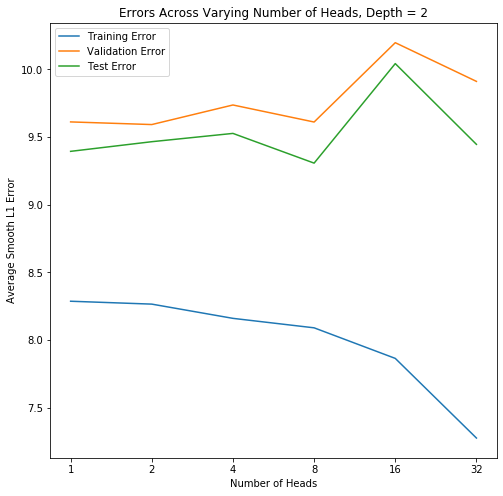

In [34]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(train_losses, label = "Training Error")
ax.plot(validate_losses, label = "Validation Error")
ax.plot(test_losses, label = "Test Error")
plt.title("Errors Across Varying Number of Heads, Depth = 2")
plt.xlabel("Number of Heads")
plt.ylabel("Average Smooth L1 Error")
ax.set_xticks(range(6))
ax.set_xticklabels(heads)
ax.legend()

### Comparing Depths at Head = 8

In [17]:
train_losses_depth = []
validate_losses_depth = []
test_losses_depth = []
depths = [1,2,3,4,5]
loss_func = F.smooth_l1_loss
_, x_train, y_train = attn_dl.load_vectorized_data('train')
_, x_validate, y_validate = attn_dl.load_vectorized_data('dev')

for depth in depths:
    model, losses = attn_model.train_model(num_epochs, batch_size, learning_rate, heads = 8, depth = depth, loss_func= loss_func)
    # Training error
    print("{} DEPTH RESULTS".format(depth))
    train_diff = loss_func(model(x_train), y_train).detach()
    print("Training Error: ", train_diff)
    ## Validation Performance
    # Total Loss on Validation Set
    total_diff = loss_func(model(x_validate), y_validate).detach()
    print("Validation Error: ", total_diff)
    # Error on test set
    i_test, x_test, y_test = attn_dl.load_vectorized_data('test')
    y_predicted = model(x_test)
    test_error = loss_func(y_predicted, y_test)
    print("Test Error: ", loss_func(y_predicted, y_test))
    print("---------------------------------")
    train_losses_depth.append(train_diff)
    validate_losses_depth.append(total_diff)
    test_losses_depth.append(test_error)

Training Model
tensor(181.3563, dtype=torch.float64)
50/50  [==============================] - 56.0s
1 DEPTH RESULTS
Training Error:  tensor(8.0295, dtype=torch.float64)
Validation Error:  tensor(9.8180, dtype=torch.float64)
Test Error:  tensor(9.6629, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)
---------------------------------
Training Model
tensor(176.9361, dtype=torch.float64)
50/50  [==============================] - 115.2s
2 DEPTH RESULTS
Training Error:  tensor(8.0228, dtype=torch.float64)
Validation Error:  tensor(9.9011, dtype=torch.float64)
Test Error:  tensor(9.8137, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)
---------------------------------
Training Model
tensor(179.8706, dtype=torch.float64)
50/50  [==============================] - 207.7s
3 DEPTH RESULTS
Training Error:  tensor(7.9707, dtype=torch.float64)
Validation Error:  tensor(9.8724, dtype=torch.float64)
Test Error:  tensor(9.6326, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)
------------

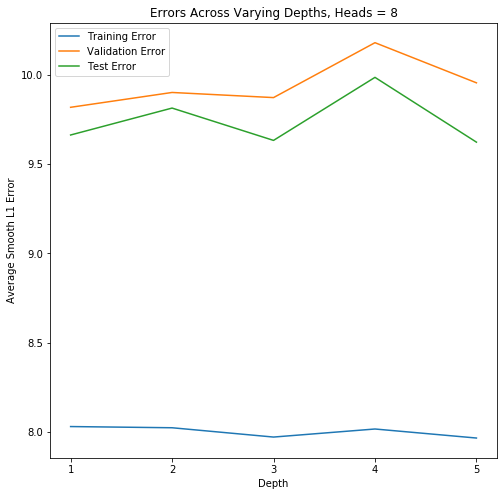

In [35]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(train_losses_depth, label = "Training Error")
ax.plot(validate_losses_depth, label = "Validation Error")
ax.plot(test_losses_depth, label = "Test Error")
plt.title("Errors Across Varying Depths, Heads = 8")
plt.xlabel("Depth")
plt.ylabel("Average Smooth L1 Error")
ax.set_xticks(range(5))
ax.set_xticklabels([1,2,3,4,5])
ax.legend()